In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time,sys
from numba import jit

In [2]:
c=299792458
scale_ex=4*np.pi*c*1e-7
scale_dx=1/c
dt = 8e-9
ddx = dt*(2*c)
KE=int(500000/ddx)
print(KE)

104238


In [3]:
round(105e-3/dt), int(105/8*1000000)

(13125000, 13125000)

In [4]:
# fp=5*10**6
# n0=fp**2/(0.897818235285877**2)/10**8
# print(n0/1e5)

In [5]:
# save_T_int=int((1e-3)/dt)
# print(save_T_int)

In [6]:
pulse_freq1=4.4*10**6
pulse_freq2=4.6*10**6
pulse_start_time=52.5e-6
pulse_end_time=152.5e-6
pulse_start_time_ind=int(pulse_start_time/dt)
pulse_end_time_ind=int(pulse_end_time/dt)

In [7]:
def Ne_to_fpe(Ne):
    # convert electron concentration to electron plasma frequency
#     return 8978.18235285877*np.sqrt(Ne)
    return 8978.18235285877*np.sqrt(np.abs(Ne)) # модуль нужен, чтобы небыло предупреждений при построении графиков из-за взятия корня от -0.
def fpe_to_Ne(fpe):
    # convert electron plasma frequency to electron concentration
    return 1.24057537429491*fpe**2*1e-8

In [17]:
# hm=250e3
z1, z2, zmax = 150000, 350000, 250000
fmax = 5000000
Nmax = fpe_to_Ne(fmax)

h_axe=np.linspace(0,(KE-1)*ddx,KE)
# n_axe=(-n0/1e10*h_axe**2+n0/2e4*h_axe-21*n0/4)*np.heaviside(h_axe-150000,0.)*(1-np.heaviside(h_axe-350000,0.))

n_axe = Nmax*(h_axe-z1)*(h_axe-z2)/(zmax-z1)/(zmax-z2)*(np.heaviside(h_axe-z1,0.)-np.heaviside(h_axe-z2,0.))
# fp_axe=np.sqrt(n_axe)*1e4*0.897818235285877
fp_axe=Ne_to_fpe(n_axe)

In [19]:
h_axe.shape

(104238,)

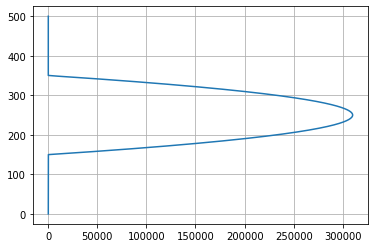

In [18]:
plt.plot(n_axe,h_axe/1000)
plt.grid()
plt.show()

In [10]:
# # Gauss
p_tstart=2.5e-6
p_tend=102.5e-6
pT_end=int(200e-6/dt)
Pulse=np.zeros(pT_end)
for T in range(pT_end):
    Pulse[T] = 0.33/2*(np.sin(2*np.pi*(pulse_freq1)*T*dt)+np.sin(2*np.pi*(pulse_freq2)*T*dt))*np.heaviside(T*dt-p_tstart,0.)*(1-np.heaviside(T*dt-p_tend,0.));
Pulse/=scale_ex   

In [11]:
pPeriod=100e-3 # период следования импульсов
pPeriod_ind=int(pPeriod/dt)
print(pPeriod_ind)

12500000


In [12]:
hmax_ind=np.where(n_axe==np.max(n_axe))[0][0]
hmax=h_axe[hmax_ind]
fof2=fp_axe[hmax_ind]
hp1=h_axe[np.where(np.abs(fp_axe[0:hmax_ind]-pulse_freq1)==np.min(np.abs(fp_axe[0:hmax_ind]-pulse_freq1)))[0][0]]
hp2=h_axe[np.where(np.abs(fp_axe[0:hmax_ind]-pulse_freq2)==np.min(np.abs(fp_axe[0:hmax_ind]-pulse_freq2)))[0][0]]

np1=(pulse_freq1/1e4/0.897818235285877)**2
np2=(pulse_freq2/1e4/0.897818235285877)**2
print(hp1,hp2,hmax,fof2,np1,np2)

202501.41119017603 210809.259786272 249998.12989603204 4999999.999125686 240175.39246349386 262505.74920080224


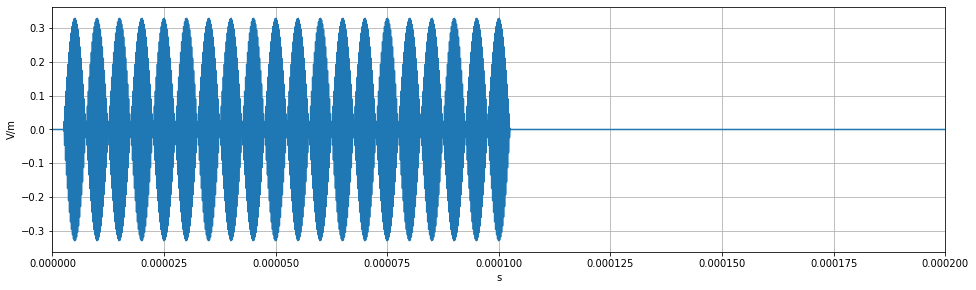

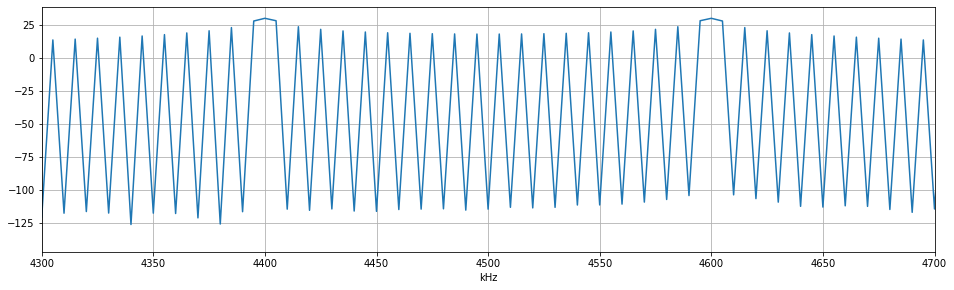

In [13]:
#  Plot pulse
t_axe=np.linspace(0,(pT_end-1)*dt,pT_end)
fig, ax = plt.subplots(figsize=(16,4.5))
plt.plot(t_axe,Pulse*scale_ex)
plt.xlim([0,pT_end*dt])
plt.xlabel('s')
plt.ylabel("V/m")
plt.grid()
plt.show()
# спектр
pfft=np.fft.rfft(Pulse*scale_ex)
pfftfreq=np.fft.rfftfreq(len(Pulse),dt)
fig, ax = plt.subplots(figsize=(16,4.5))
plt.plot(pfftfreq/1000,10*np.log10(np.abs(pfft)))
plt.grid()
plt.xlim(4.5e3-200,4.5e3+200)
plt.xlabel('kHz')
plt.show()

##  Модель возмущения параболического слоя

In [49]:
f_pump = 4600000
N_pump = fpe_to_Ne(4600000)
print(N_pump)
z0 = h_axe[np.abs(n_axe[0:50000] - N_pump).argmin()]
print(z0)
dN = 0.1*N_pump
print(dN)
d_z = 3000
t_r, t_d, tau_r, tau_d = 0., 6., 10., 10.
def DN(T):
    DN_max = -dN*np.exp(-(h_axe-z0)**2/2/d_z**2)
    f = (1-np.exp(-(T*dt-t_r)/tau_r))*(np.heaviside(T*dt-t_r,0)-(np.heaviside(T*dt-t_d,0)))+(1-np.exp(-(t_d-t_r)/tau_r))*np.exp(-(T*dt-t_d)/tau_d)*np.heaviside(T*dt-t_d,0)
    return DN_max*f

262505.74920080294
210809.259786272
26250.574920080297


In [52]:
# dn_h0=hp2 # центр возмущения
# dn_sigma=3e3 # ширина возмущения
# dn_amp=0.1*np2 # амплитуда возмущения
# # dn_tau=100e-6 # характерное время нарастания возмущения [100 мкс] 
# dn_tau=10. # характерное время нарастания возмущения [10 с] 
# dn_t0=0. # время начала возмущения
# # print(dn_h0, dn_sigma, dn_amp)
# def DN(T):
#     dn=-dn_amp*np.exp(-(h_axe-dn_h0)**2/2/dn_sigma**2)*(1-np.exp(-(T*dt-dn_t0)/dn_tau))
#     return dn*np.heaviside(h_axe-(dn_h0-3*dn_sigma),1.)*(1-np.heaviside(h_axe-(dn_h0+3*dn_sigma),1.))

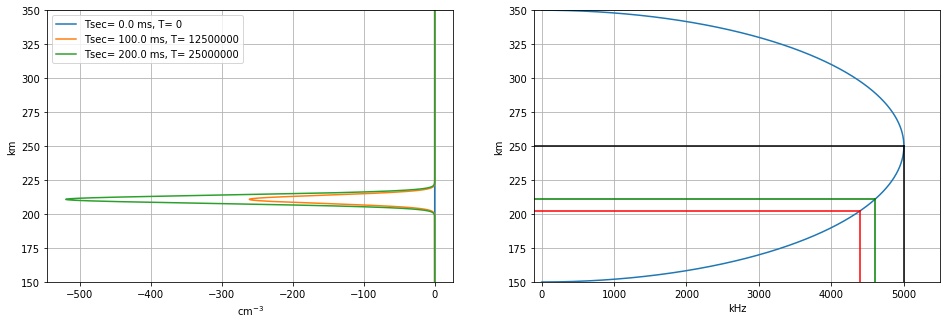

In [54]:
#  Plot profile
fig = plt.figure(figsize=(16,5))
ax1 = plt.subplot('121')
T_sec=0.
T=int(T_sec/dt)
plt.plot(DN(T),h_axe/1000, label='Tsec= '+str(T_sec*1000)+' ms, T= '+str(T))
T_sec=100e-3
T=int(T_sec/dt)
plt.plot(DN(T),h_axe/1000, label='Tsec= '+str(T_sec*1000)+' ms, T= '+str(T))
T_sec=200e-3
T=int(T_sec/dt)
plt.plot(DN(T),h_axe/1000, label='Tsec= '+str(T_sec*1000)+' ms, T= '+str(T))
plt.legend(loc=0)
plt.xlabel('cm$^{-3}$')
plt.ylabel('km')
plt.ylim([150,350])
plt.grid()

ax2 = plt.subplot('122')
plt.plot(fp_axe/1000,h_axe/1000)
plt.plot([pulse_freq1/1e3,pulse_freq1/1e3],[0,hp1/1000],'r')
plt.plot([-100,pulse_freq1/1e3],[hp1/1000,hp1/1000],'r')
plt.plot([pulse_freq2/1e3,pulse_freq2/1e3],[0,hp2/1000],'g')
plt.plot([-100,pulse_freq2/1e3],[hp2/1000,hp2/1000],'g')

plt.plot([fof2/1e3,fof2/1e3],[0,hmax/1000],'k')
plt.plot([-100,fof2/1e3],[hmax/1000,hmax/1000],'k')

plt.xlabel('kHz')
plt.ylabel('km')
plt.xlim([-100,5500])
plt.ylim([150,350])
plt.grid()
plt.show()

In [55]:
# plasma 
plasma_st_ind=int(150e3/ddx)
plasma_end_ind=int(350e3/ddx)
fp=5*10**6
n0=fp**2/(0.897818235285877**2)/10**8

omega=2*np.pi*np.sqrt((0.897818235285877**2)*1e8*(n_axe))
omega2=2*np.pi*np.sqrt((0.897818235285877**2)*1e8*(n_axe+DN(12500000)))
omega3=2*np.pi*np.sqrt((0.897818235285877**2)*1e8*(n_axe+DN(25000000)))
nu=1000.
# vc[:]=nu

dx_old_1 = 0.
dx_old_N_1=0.

pulse_num=0

In [56]:
@jit(nopython=True)
def fdtd_steps(T_end):
    dx=np.zeros(KE)
    ex=np.zeros(KE)
    hy=np.zeros(KE-1)
    sx=np.zeros(KE)
    sxm1=np.zeros(KE)
    sxm2=np.zeros(KE)
    omega=np.zeros(KE)
    vc=np.zeros(KE)
    L=KE*ddx
    
    p_start_inds=[0] # индексы, когда начинается очередной период импульса
    for i in range(1,int(np.ceil(T_end/pPeriod_ind))):
        p_start_inds.append(i*pPeriod_ind)
    print(p_start_inds) 
    
    # plasma 
    plasma_st_ind=int(150e3/ddx)
    plasma_end_ind=int(350e3/ddx)
    fp=5*10**6
    n0=fp**2/(0.897818235285877**2)/10**8

    omega=2*np.pi*np.sqrt((0.897818235285877**2)*1e8*(n_axe))
    nu=1000.
    vc[:]=nu

    dx_old_1 = 0.
    dx_old_N_1=0.

    pulse_num=0
    E_max=np.zeros(T_end)
    
    for T in range(1,T_end):

        if T>1 and T%125000==0:
            print(T)
        dx_old_1 = dx[1]
        dx_old_N_1 = dx[-2]
        dx[1:-1] = dx[1:-1] - 0.5*( hy[1:] - hy[0:-1])
        if len(p_start_inds)>1:
            if T==p_start_inds[1]:        
                pulse_num+=1    #       
                omega[:]=omega2[:]
        if len(p_start_inds)>2:
            if T==p_start_inds[2]:        
                pulse_num+=1
                omega[:]=omega3[:]            
            
        if T-p_start_inds[pulse_num]<pT_end:
            dx[5] = dx[5] + Pulse[T-p_start_inds[pulse_num]];

        dx[0] = dx_old_1+(-1/3)*(dx[1]-dx[0]); # bc0    
        dx[-1]=dx_old_N_1+(-1/3)*(dx[-2]-dx[-1]); # bcN

        ex[:]=dx[:]-sx[:]
    #     ex=ne.evaluate("dx-sx")
        E_max[T]=ex[5]
        sx[:]=(1+np.exp(-vc*dt))*sxm1[:] - np.exp(-vc*dt)*sxm2[:] + omega**2*dt/vc*(1-np.exp(-vc*dt))*ex[:]
    #     sx=ne.evaluate("(1+exp(-vc*dt))*sxm1 - exp(-vc*dt)*sxm2 + omega**2*dt/vc*(1-exp(-vc*dt))*ex")
        sxm2[:]=sxm1[:]
        sxm1[:]=sx[:]             
        hy[:] = hy[:] - .5*(ex[1:] - ex[0:-1]);   
    return E_max
print(round(1e-5/dt))
E_max_test=fdtd_steps(round(1e-5/dt))

1250
[0]


In [57]:
print(round(1e-3/dt))

125000


In [58]:
start = time.time()
E_max_test=fdtd_steps(round(1e-5/dt))
end = time.time()
print("Elapsed (after compilation) = %s" % (end - start))

[0]
Elapsed (after compilation) = 1.2081224918365479


In [60]:
start = time.time()
E_max=fdtd_steps(round(5e-3/dt))
end = time.time()
print("Elapsed = %s" % (end - start))
E_max.tofile('Ex_max_5ms.bin')

[0]
125000
250000
375000
500000
Elapsed (after compilation) = 610.1264231204987


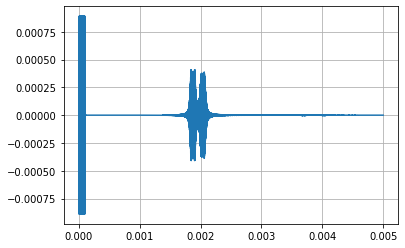

In [62]:
Ex_load=np.fromfile('Ex_max_5ms.bin')
t_axe=np.linspace(0,(round(5e-3/dt)-1)*dt,round(5e-3/dt))
plt.plot(t_axe,Ex_load)
# plt.xlim(15e-4,25e-4)
# plt.xlim(15e-4+100e-3,25e-4+100e-3)
plt.grid()
plt.show()

In [65]:
# start = time.time()
# E_max=fdtd_steps(round(105e-3/dt))
# end = time.time()
# print("Elapsed = %s" % (end - start))
# E_max.tofile('Ex_max_105ms.bin')

In [66]:
# Ex_load=np.fromfile('Ex_max_105ms.bin')
# t_axe=np.linspace(0,(round(105e-3/dt)-1)*dt,round(105e-3/dt))
# plt.plot(t_axe,Ex_load)
# # plt.xlim(15e-4,25e-4)
# # plt.xlim(15e-4+100e-3,25e-4+100e-3)
# plt.grid()
# plt.show()

In [61]:
start = time.time()
E_max=fdtd_steps(round(205e-3/dt))
end = time.time()
print("Elapsed = %s" % (end - start))
E_max.tofile('Ex_max_205ms.bin')

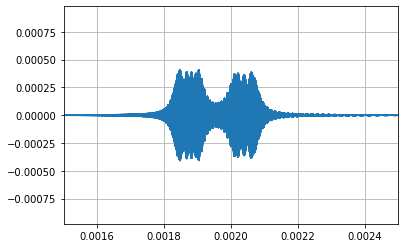

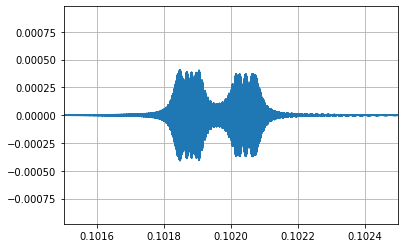

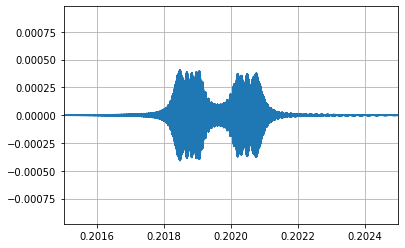

In [41]:
Ex_load=np.fromfile('Ex_max_205ms.bin')
t_axe=np.linspace(0,(round(205e-3/dt)-1)*dt,round(205e-3/dt))
plt.figure()
plt.plot(t_axe,Ex_load)
plt.xlim(15e-4,25e-4)
plt.grid()
plt.show()
plt.figure()
plt.plot(t_axe,Ex_load)
plt.xlim(15e-4+100e-3,25e-4+100e-3)
plt.grid()
plt.show()
plt.figure()
plt.plot(t_axe,Ex_load)
plt.xlim(15e-4+200e-3,25e-4+200e-3)
plt.grid()
plt.show()

In [64]:
# t_axe=np.linspace(0,(T_end-1)*dt,T_end)
# plt.plot(t_axe,Ex_load)
# plt.xlim(0,105e-6)
# plt.grid()
# plt.show()